# Improved Notebook – Train All Models on Full Data



In [16]:
import pandas as pd
import numpy as np
import joblib
import warnings
from typing import Tuple

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

warnings.filterwarnings('ignore')

## Data Loading, Aggregation, and Feature Engineering

In [17]:
def aggregate_player_data(df: pd.DataFrame, agg_funcs=None, prefix="") -> pd.DataFrame:
    if agg_funcs is None:
        agg_funcs = {col: 'mean' for col in df.columns if col != 'ID'}
    aggregated = df.groupby("ID").agg(agg_funcs).reset_index()
    if prefix:
        aggregated = aggregated.rename(
            columns={col: f"{prefix}_{col}" for col in aggregated.columns if col != "ID"}
        )
    return aggregated

def pre_aggregate_player_data(player_path: str, drop_columns: list[str], prefix: str = "") -> pd.DataFrame:
    df = pd.read_csv(player_path)
    df = df.drop(drop_columns, axis=1, errors="ignore")
    aggregated = aggregate_player_data(df, prefix=prefix)
    aggregated = aggregated.groupby("ID").mean().reset_index()
    return aggregated

def process_team_data(file_path: str, drop_columns: list[str], prefix: str) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    df = df.drop(drop_columns, axis=1, errors="ignore")
    df = df.rename(columns={col: f"{prefix}_{col}" for col in df.columns if col != "ID"})
    return df

def calculate_diff_and_ratio(df: pd.DataFrame) -> pd.DataFrame:
    for stat in ["SHOTS_TOTAL", "SHOTS_ON_TARGET", "GOALS", "DANGEROUS_ATTACKS", "REDCARDS", "FOULS"]:
        home_stat = f"home_{stat}_season_sum"
        away_stat = f"away_{stat}_season_sum"
        if home_stat in df.columns and away_stat in df.columns:
            df[f"{stat}_DIFF"] = df[home_stat] - df[away_stat]
            df[f"{stat}_RATIO"] = df[home_stat] / (df[away_stat] + 1)
    return df

def encode_multiclass_targets(df: pd.DataFrame, cols: list) -> pd.Series:
    arr = df[cols].values
    return np.argmax(arr, axis=1)

def load_and_merge_train_data(
    home_team_path: str,
    away_team_path: str,
    home_players_path: str,
    away_players_path: str,
    target_path: str
) -> Tuple[pd.DataFrame, pd.Series]:
    # Process team data
    df_home_team = process_team_data(home_team_path, drop_columns=["LEAGUE", "TEAM_NAME"], prefix="home")
    df_away_team = process_team_data(away_team_path, drop_columns=["LEAGUE", "TEAM_NAME"], prefix="away")
    targets = pd.read_csv(target_path)
    
    # Pre-aggregate player data
    df_home_players_agg = pre_aggregate_player_data(
        home_players_path,
        ["LEAGUE", "TEAM_NAME", "PLAYER_NAME", "POSITION"],
        prefix="home"
    )
    df_away_players_agg = pre_aggregate_player_data(
        away_players_path,
        ["LEAGUE", "TEAM_NAME", "PLAYER_NAME", "POSITION"],
        prefix="away"
    )

    # Merge team data with aggregated player data
    merged_home = df_home_team.merge(df_home_players_agg, on="ID", how="left").fillna(0)
    merged_away = df_away_team.merge(df_away_players_agg, on="ID", how="left").fillna(0)

    # Final merge (home is base)
    merged_data = merged_home.merge(merged_away, on="ID", how="left").fillna(0)
    merged_data = merged_data.merge(targets, on="ID", how="inner").fillna(0)

    # Diff & Ratio
    merged_data = calculate_diff_and_ratio(merged_data)

    # Encode targets
    y = encode_multiclass_targets(merged_data, ["HOME_WINS", "DRAW", "AWAY_WINS"])
    merged_data.drop(["HOME_WINS", "DRAW", "AWAY_WINS", "ID"], axis=1, inplace=True)
    return merged_data, y

def load_and_merge_test_data(
    home_team_test_path: str,
    away_team_test_path: str,
    home_players_test_path: str,
    away_players_test_path: str
) -> pd.DataFrame:
    df_home_team = process_team_data(home_team_test_path, drop_columns=["LEAGUE", "TEAM_NAME"], prefix="home")
    df_away_team = process_team_data(away_team_test_path, drop_columns=["LEAGUE", "TEAM_NAME"], prefix="away")
    print(f"Processed team data: Home team -> {df_home_team.shape}, Away team -> {df_away_team.shape}")

    df_home_players_agg = pre_aggregate_player_data(
        home_players_test_path,
        ["LEAGUE", "TEAM_NAME", "PLAYER_NAME", "POSITION"],
        prefix="home"
    )
    df_away_players_agg = pre_aggregate_player_data(
        away_players_test_path,
        ["LEAGUE", "TEAM_NAME", "PLAYER_NAME", "POSITION"],
        prefix="away"
    )
    print(f"Pre-aggregated player data: Home players -> {df_home_players_agg.shape}, Away players -> {df_away_players_agg.shape}")

    merged_home = df_home_team.merge(df_home_players_agg, on="ID", how="left").fillna(0)
    merged_away = df_away_team.merge(df_away_players_agg, on="ID", how="left").fillna(0)
    print(f"Merged home shape -> {merged_home.shape}")
    print(f"Merged away shape -> {merged_away.shape}")

    merged_test = merged_home.merge(merged_away, on="ID", how="left").fillna(0)
    print(f"Final merged test data shape -> {merged_test.shape}")
    return merged_test

## Load Training Data & Quick Exploration

In [18]:
train_home_team_csv = "data/Train_Data/train_home_team_statistics_df.csv"
train_away_team_csv = "data/Train_Data/train_away_team_statistics_df.csv"
train_home_players_csv = "data/Train_Data/train_home_player_statistics_df.csv"
train_away_players_csv = "data/Train_Data/train_away_player_statistics_df.csv"
y_csv = "data/Y_train_1rknArQ.csv"

X_raw, y_raw = load_and_merge_train_data(
    train_home_team_csv,
    train_away_team_csv,
    train_home_players_csv,
    train_away_players_csv,
    y_csv
)

print("Shape of training data:", X_raw.shape)
print("Unique target classes:", np.unique(y_raw))


Shape of training data: (12303, 884)
Unique target classes: [0 1 2]


### Quick EDA

Summary stats (head):


,count,mean,std,min,25%,50%,75%,max
home_TEAM_SHOTS_TOTAL_season_sum,12303.0,4.298383,2.909931,0.0,2.0,4.0,6.0,10.0
home_TEAM_SHOTS_INSIDEBOX_season_sum,12303.0,3.815817,3.074941,0.0,1.0,3.0,6.0,10.0
home_TEAM_SHOTS_OFF_TARGET_season_sum,12303.0,4.511339,2.806821,0.0,2.0,4.0,6.0,10.0
home_TEAM_SHOTS_ON_TARGET_season_sum,12303.0,4.150207,2.861548,0.0,2.0,4.0,6.0,10.0
home_TEAM_SHOTS_OUTSIDEBOX_season_sum,12303.0,4.014549,3.038104,0.0,1.0,4.0,6.0,10.0
home_TEAM_PASSES_season_sum,12303.0,3.850931,3.067556,0.0,1.0,3.0,6.0,10.0
home_TEAM_SUCCESSFUL_PASSES_season_sum,12303.0,3.665447,3.028115,0.0,1.0,3.0,6.0,10.0
home_TEAM_SAVES_season_sum,12303.0,4.377713,3.003680,0.0,2.0,4.0,7.0,10.0
home_TEAM_CORNERS_season_sum,12303.0,4.504917,2.802869,0.0,2.0,4.0,6.0,10.0
home_TEAM_FOULS_season_sum,12303.0,4.819719,3.015164,0.0,3.0,5.0,7.0,10.0


Class distribution:
0    5356
2    3761
1    3186
Name: count, dtype: int64


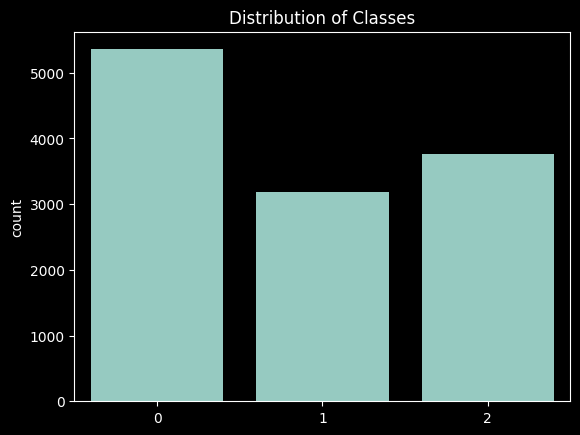

In [19]:
print("Summary stats (head):")
display(X_raw.describe().T.head(10))

print("Class distribution:")
class_counts = pd.Series(y_raw).value_counts()
print(class_counts)

sns.countplot(x=y_raw)
plt.title("Distribution of Classes")
plt.show()

## Hyperparameter Tuning on Sample

In [22]:
# Optional sampling for faster tuning
sample_frac = 1
X_sample = X_raw.sample(frac=sample_frac, random_state=42)
y_sample = y_raw[X_sample.index]

print("Shape of sampled data for tuning:", X_sample.shape)

X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(
    X_sample, y_sample,
    test_size=0.2,
    random_state=42,
    stratify=y_sample
)
print("X_train_s shape:", X_train_s.shape, "X_val_s shape:", X_val_s.shape)


Shape of sampled data for tuning: (12303, 884)
X_train_s shape: (9842, 884) X_val_s shape: (2461, 884)


### Models and RandomizedSearchCV

In [23]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st

models = {
    "LogisticRegression": {
        "estimator": LogisticRegression(max_iter=2000, solver="lbfgs", n_jobs=-1),
        "param_dist": {
            "C": st.loguniform(1e-2, 1e1)
        }
    },
    "RandomForest": {
        "estimator": RandomForestClassifier(random_state=42, n_jobs=-1),
        "param_dist": {
            "n_estimators": st.randint(50, 300),
            "max_depth": st.randint(3, 15)
        }
    },
    "XGBClassifier": {
        "estimator": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="mlogloss", n_jobs=-1),
        "param_dist": {
            "n_estimators": st.randint(50, 300),
            "max_depth": st.randint(3, 15),
            "learning_rate": st.loguniform(1e-3, 1e-1)
        }
    },
    "LGBMClassifier": {
        "estimator": LGBMClassifier(random_state=42, n_jobs=-1),
        "param_dist": {
            "n_estimators": st.randint(50, 300),
            "max_depth": st.randint(3, 15),
            "learning_rate": st.loguniform(1e-3, 1e-1)
        }
    }
}

n_iter_search = 20
results = {}

for name, cfg in models.items():
    print(f"Tuning {name} with RandomizedSearchCV...")
    clf = cfg["estimator"]
    param_dist = cfg["param_dist"]

    rs = RandomizedSearchCV(
        estimator=clf,
        param_distributions=param_dist,
        n_iter=n_iter_search,
        scoring="accuracy",
        cv=3,
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    rs.fit(X_train_s, y_train_s)
    best_model = rs.best_estimator_
    val_preds = best_model.predict(X_val_s)
    acc = accuracy_score(y_val_s, val_preds)
    f1 = f1_score(y_val_s, val_preds, average="macro")

    results[name] = {
        "best_params": rs.best_params_,
        "accuracy": acc,
        "f1_score": f1,
        "best_estimator": best_model
    }
    print(f"{name} tuned. Accuracy: {acc:.4f}, F1 Score: {f1:.4f}\n")

Tuning LogisticRegression with RandomizedSearchCV...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/jonas/Documents/github/ml_project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jonas/Documents/github/ml_project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

LogisticRegression tuned. Accuracy: 0.4628, F1 Score: 0.4104

Tuning RandomForest with RandomizedSearchCV...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
RandomForest tuned. Accuracy: 0.5063, F1 Score: 0.3681

Tuning XGBClassifier with RandomizedSearchCV...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/jonas/Documents/github/ml_project/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:05:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jonas/Documents/github/ml_project/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:05:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jonas/Documents/github/ml_project/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:05:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jonas/Documents/github/ml_project/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:05:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740:

XGBClassifier tuned. Accuracy: 0.4986, F1 Score: 0.3634

Tuning LGBMClassifier with RandomizedSearchCV...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 132509
[LightGBM] [Info] Number of data points in the train set: 6562, number of used features: 840
[LightGBM] [Info] Start training from score -0.831873
[LightGBM] [Info] Start training from score -1.350667
[LightGBM] [Info] Start training from score -1.185153
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 132413
[LightGBM] [Info] Number of data points in the train set: 6561, number of used features: 840
[LightGBM] [Info] Start training from score -0.831721
[LightGBM] [Info] Start training fr

In [24]:
# Summarize tuning results on the sample.
comparison = pd.DataFrame(
    [
        [mn, md["accuracy"], md["f1_score"], md["best_params"]]
        for mn, md in results.items()
    ],
    columns=["Model", "Accuracy", "F1 Score", "Best Params"]
)
display(comparison)

,Model,Accuracy,F1 Score,Best Params
0,LogisticRegression,0.462820,0.410409,{'C': 0.011527987128232402}
1,RandomForest,0.506298,0.368070,"{'max_depth': 10, 'n_estimators': 201}"
2,XGBClassifier,0.498578,0.363373,"{'learning_rate': 0.00796156607806295, 'max_de..."
3,LGBMClassifier,0.503048,0.372425,"{'learning_rate': 0.01067748270948136, 'max_de..."


## Train **All** Models on Full Data

In [25]:
X_train_full, X_val_full, y_train_full, y_val_full = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=42, stratify=y_raw
)
print("Shapes:", X_train_full.shape, X_val_full.shape)

all_final_models = {}
for model_name, info in results.items():
    best_params = info["best_params"]
    print(f"\nRetraining {model_name} with best params -> {best_params}")

    if model_name == "LogisticRegression":
        model = LogisticRegression(max_iter=2000, solver="lbfgs", n_jobs=-1, **best_params)
    elif model_name == "RandomForest":
        model = RandomForestClassifier(random_state=42, n_jobs=-1, **best_params)
    elif model_name == "XGBClassifier":
        model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="mlogloss", n_jobs=-1, **best_params)
    else:
        model = LGBMClassifier(random_state=42, n_jobs=-1, **best_params)

    # Fit on full training portion.
    model.fit(X_train_full, y_train_full)
    preds = model.predict(X_val_full)
    acc = accuracy_score(y_val_full, preds)
    f1 = f1_score(y_val_full, preds, average="macro")

    print(f"{model_name} -> Accuracy on full data: {acc:.4f}, F1: {f1:.4f}")

    all_final_models[model_name] = model

Shapes: (9842, 884) (2461, 884)

Retraining LogisticRegression with best params -> {'C': np.float64(0.011527987128232402)}


/Users/jonas/Documents/github/ml_project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression -> Accuracy on full data: 0.4474, F1: 0.3955

Retraining RandomForest with best params -> {'max_depth': 10, 'n_estimators': 201}
RandomForest -> Accuracy on full data: 0.4896, F1: 0.3522

Retraining XGBClassifier with best params -> {'learning_rate': np.float64(0.00796156607806295), 'max_depth': 4, 'n_estimators': 181}
XGBClassifier -> Accuracy on full data: 0.4823, F1: 0.3516

Retraining LGBMClassifier with best params -> {'learning_rate': np.float64(0.01067748270948136), 'max_depth': 11, 'n_estimators': 180}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 133537
[LightGBM] [Info] Number of data points in the train set: 9842, number of used features: 840
[LightGBM] [Info] Start training from score -0.831772
[LightGBM] [Info] Start training from score -1.350958
[LightGBM] [Info] Start training from score -1.185051
LGBMClassifi

### Evaluate & Save Each Final Model


Confusion matrix for LogisticRegression:


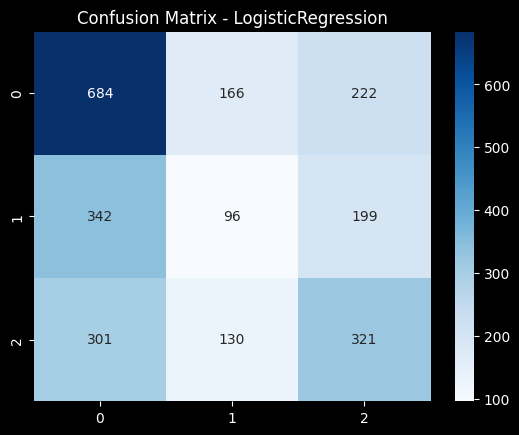

Classification report:
              precision    recall  f1-score   support

           0       0.52      0.64      0.57      1072
           1       0.24      0.15      0.19       637
           2       0.43      0.43      0.43       752

    accuracy                           0.45      2461
   macro avg       0.40      0.41      0.40      2461
weighted avg       0.42      0.45      0.43      2461

Saved model_LogisticRegression.pkl

Confusion matrix for RandomForest:


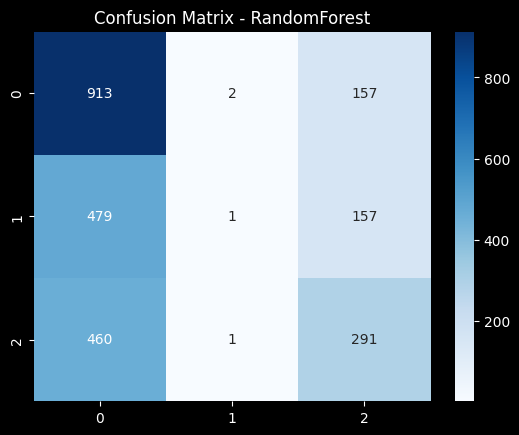

Classification report:
              precision    recall  f1-score   support

           0       0.49      0.85      0.62      1072
           1       0.25      0.00      0.00       637
           2       0.48      0.39      0.43       752

    accuracy                           0.49      2461
   macro avg       0.41      0.41      0.35      2461
weighted avg       0.43      0.49      0.40      2461

Saved model_RandomForest.pkl

Confusion matrix for XGBClassifier:


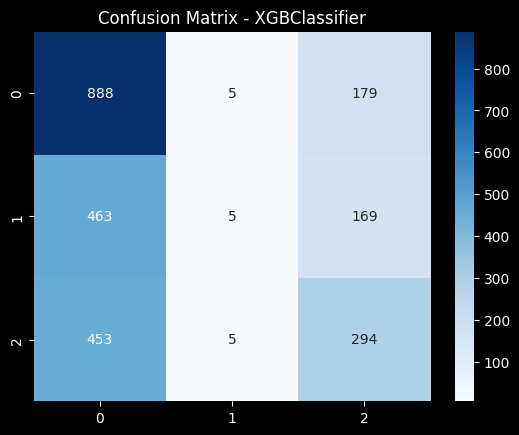

Classification report:
              precision    recall  f1-score   support

           0       0.49      0.83      0.62      1072
           1       0.33      0.01      0.02       637
           2       0.46      0.39      0.42       752

    accuracy                           0.48      2461
   macro avg       0.43      0.41      0.35      2461
weighted avg       0.44      0.48      0.40      2461

Saved model_XGBClassifier.pkl

Confusion matrix for LGBMClassifier:


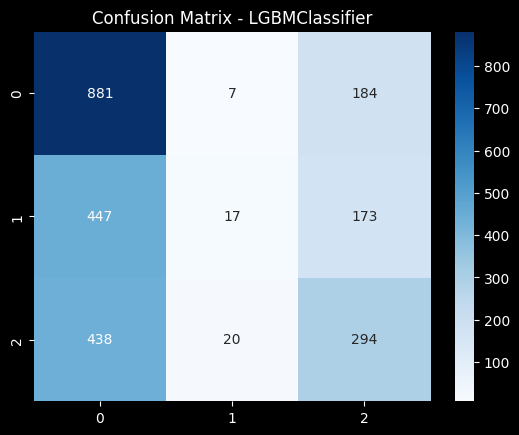

Classification report:
              precision    recall  f1-score   support

           0       0.50      0.82      0.62      1072
           1       0.39      0.03      0.05       637
           2       0.45      0.39      0.42       752

    accuracy                           0.48      2461
   macro avg       0.45      0.41      0.36      2461
weighted avg       0.46      0.48      0.41      2461

Saved model_LGBMClassifier.pkl


In [26]:
for mname, mdl in all_final_models.items():
    print(f"\nConfusion matrix for {mname}:")
    cm = confusion_matrix(y_val_full, mdl.predict(X_val_full))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {mname}")
    plt.show()

    print("Classification report:")
    print(classification_report(y_val_full, mdl.predict(X_val_full)))

    # Save each model
    joblib.dump(mdl, f"model_{mname}.pkl")
    print(f"Saved model_{mname}.pkl")

## Load Test Data & Create Submissions for **Each** Model

In [27]:
test_home_team_csv = "data/Test_Data/test_home_team_statistics_df.csv"
test_away_team_csv = "data/Test_Data/test_away_team_statistics_df.csv"
test_home_players_csv = "data/Test_Data/test_home_player_statistics_df.csv"
test_away_players_csv = "data/Test_Data/test_away_player_statistics_df.csv"

X_test_raw = load_and_merge_test_data(
    test_home_team_csv,
    test_away_team_csv,
    test_home_players_csv,
    test_away_players_csv
)

print("Shape of test data:", X_test_raw.shape)

# If there are duplicates, group by ID
before = X_test_raw.shape[0]
X_test_raw = X_test_raw.groupby("ID", as_index=False).first()
after = X_test_raw.shape[0]
print(f"Dropped {before - after} duplicates. Unique test IDs: {after}.")

test_ids = X_test_raw["ID"].values
X_test = X_test_raw.drop("ID", axis=1)
print("X_test shape:", X_test.shape)

Processed team data: Home team -> (25368, 141), Away team -> (25368, 141)
Pre-aggregated player data: Home players -> (25368, 303), Away players -> (25368, 303)
Merged home shape -> (25368, 443)
Merged away shape -> (25368, 443)
Final merged test data shape -> (25368, 885)
Shape of test data: (25368, 885)
Dropped 0 duplicates. Unique test IDs: 25368.
X_test shape: (25368, 884)


### Predict & Save Each Submission

In [28]:
mapping = {0: [1, 0, 0], 1: [0, 1, 0], 2: [0, 0, 1]}

for mname, mdl in all_final_models.items():
    print(f"Creating submission for {mname}...")
    preds = mdl.predict(X_test)
    submission_data = [[id_, *mapping[label]] for id_, label in zip(test_ids, preds)]
    submission = pd.DataFrame(submission_data, columns=["ID", "HOME_WINS", "DRAW", "AWAY_WINS"])
    fname = f"submission_{mname}.csv"
    submission.to_csv(fname, index=False)
    print(f"Saved {fname}")

Creating submission for LogisticRegression...
Saved submission_LogisticRegression.csv
Creating submission for RandomForest...
Saved submission_RandomForest.csv
Creating submission for XGBClassifier...
Saved submission_XGBClassifier.csv
Creating submission for LGBMClassifier...
Saved submission_LGBMClassifier.csv
